In [2]:
from keys import FTX_API_KEY, FTX_API_SECRET
import seaborn as sns
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utility_classes.correlation import Correlation, CSVManager
from utility_classes.historical_data_processor import FTXDataProcessor
import seaborn as sns 
import dateutil.parser as dp
from matplotlib.pyplot import figure



acc = FTXDataProcessor(api_key=FTX_API_KEY, api_secret=FTX_API_SECRET)
corr = Correlation(
        spread_folder_path='/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/all_spreads',
        perp_folder_path='/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/all_perps',
        futures_folder_path='/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/expired_futures_data')

plt.rcParams['figure.figsize'] = [15, 15]


## Pearson's coefficient for spreads
### draw the daily spread heatmap for futures expiring in 2020/09/25 and 2020/12/25, with minimum value set to 0 


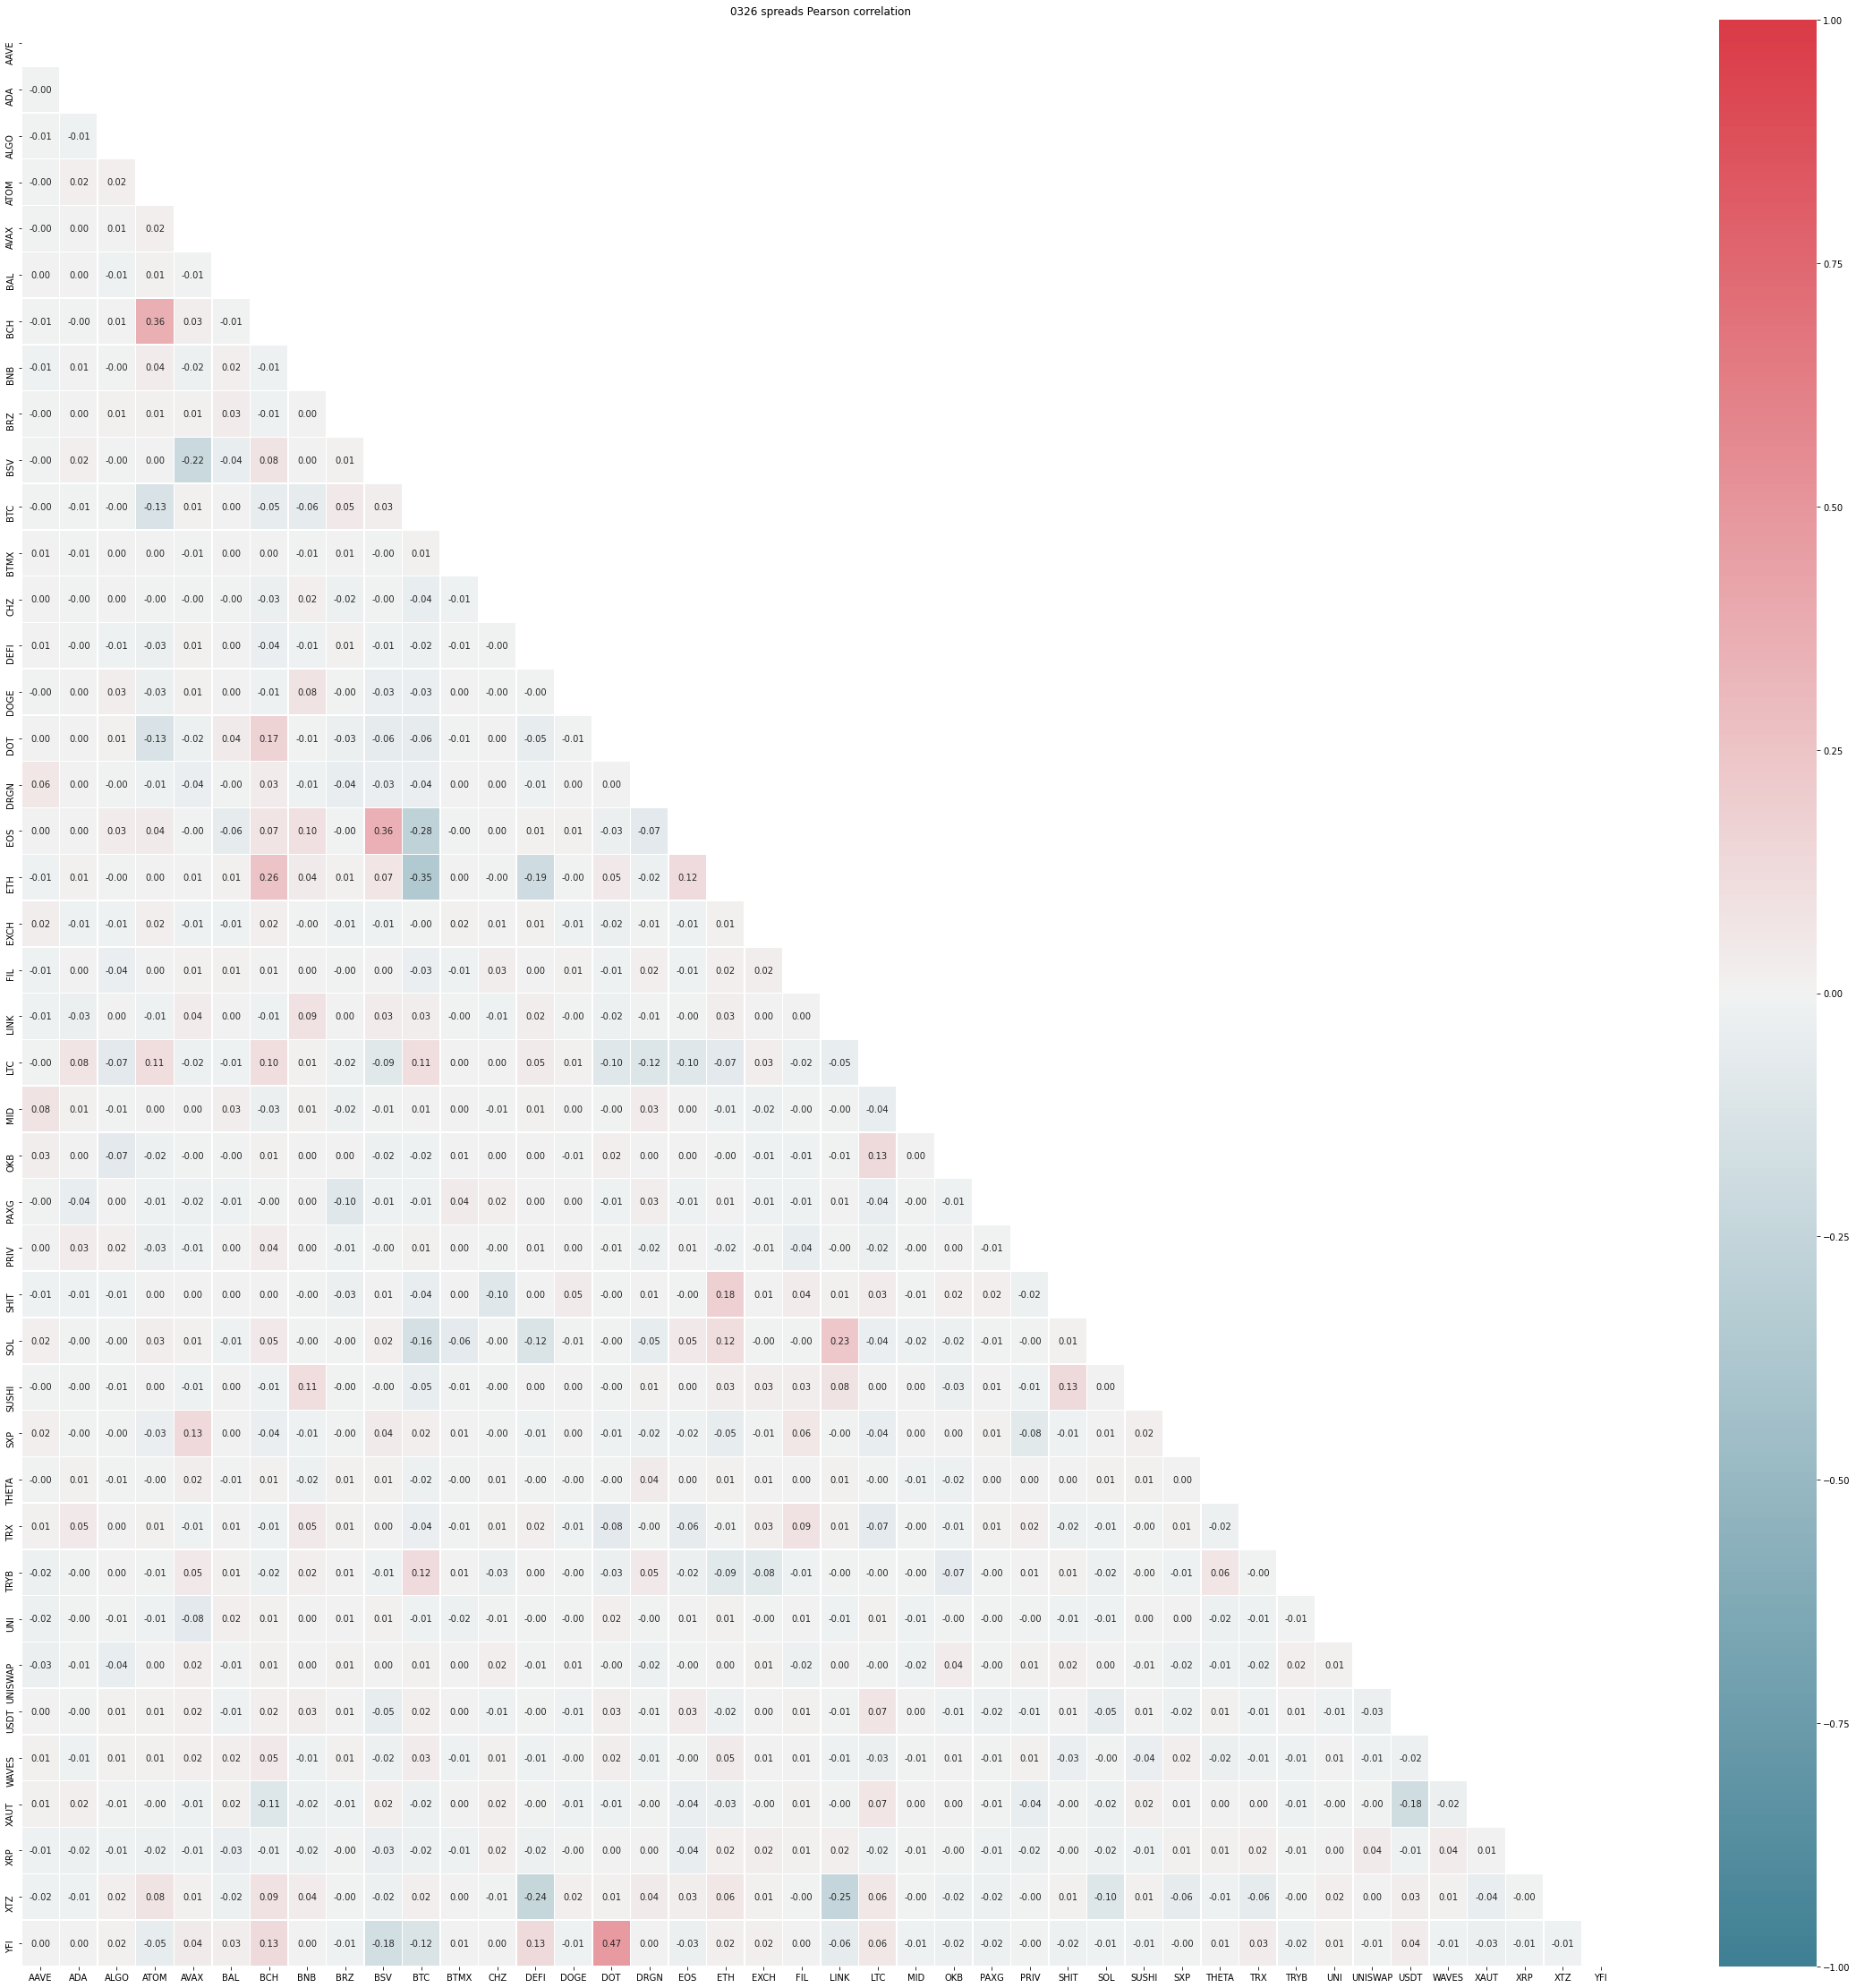

spreads from 2020-12-14T07:27:00+00:00 to 2021-03-26T03:00:00+00:00
['BCH', 'BNB', 'BTC', 'BTMX', 'DEFI', 'DOT', 'EOS', 'ETH', 'FIL', 'LTC', 'SOL', 'SUSHI', 'TRYB', 'USDT', 'WAVES', 'XRP', 'XTZ'] have missing values


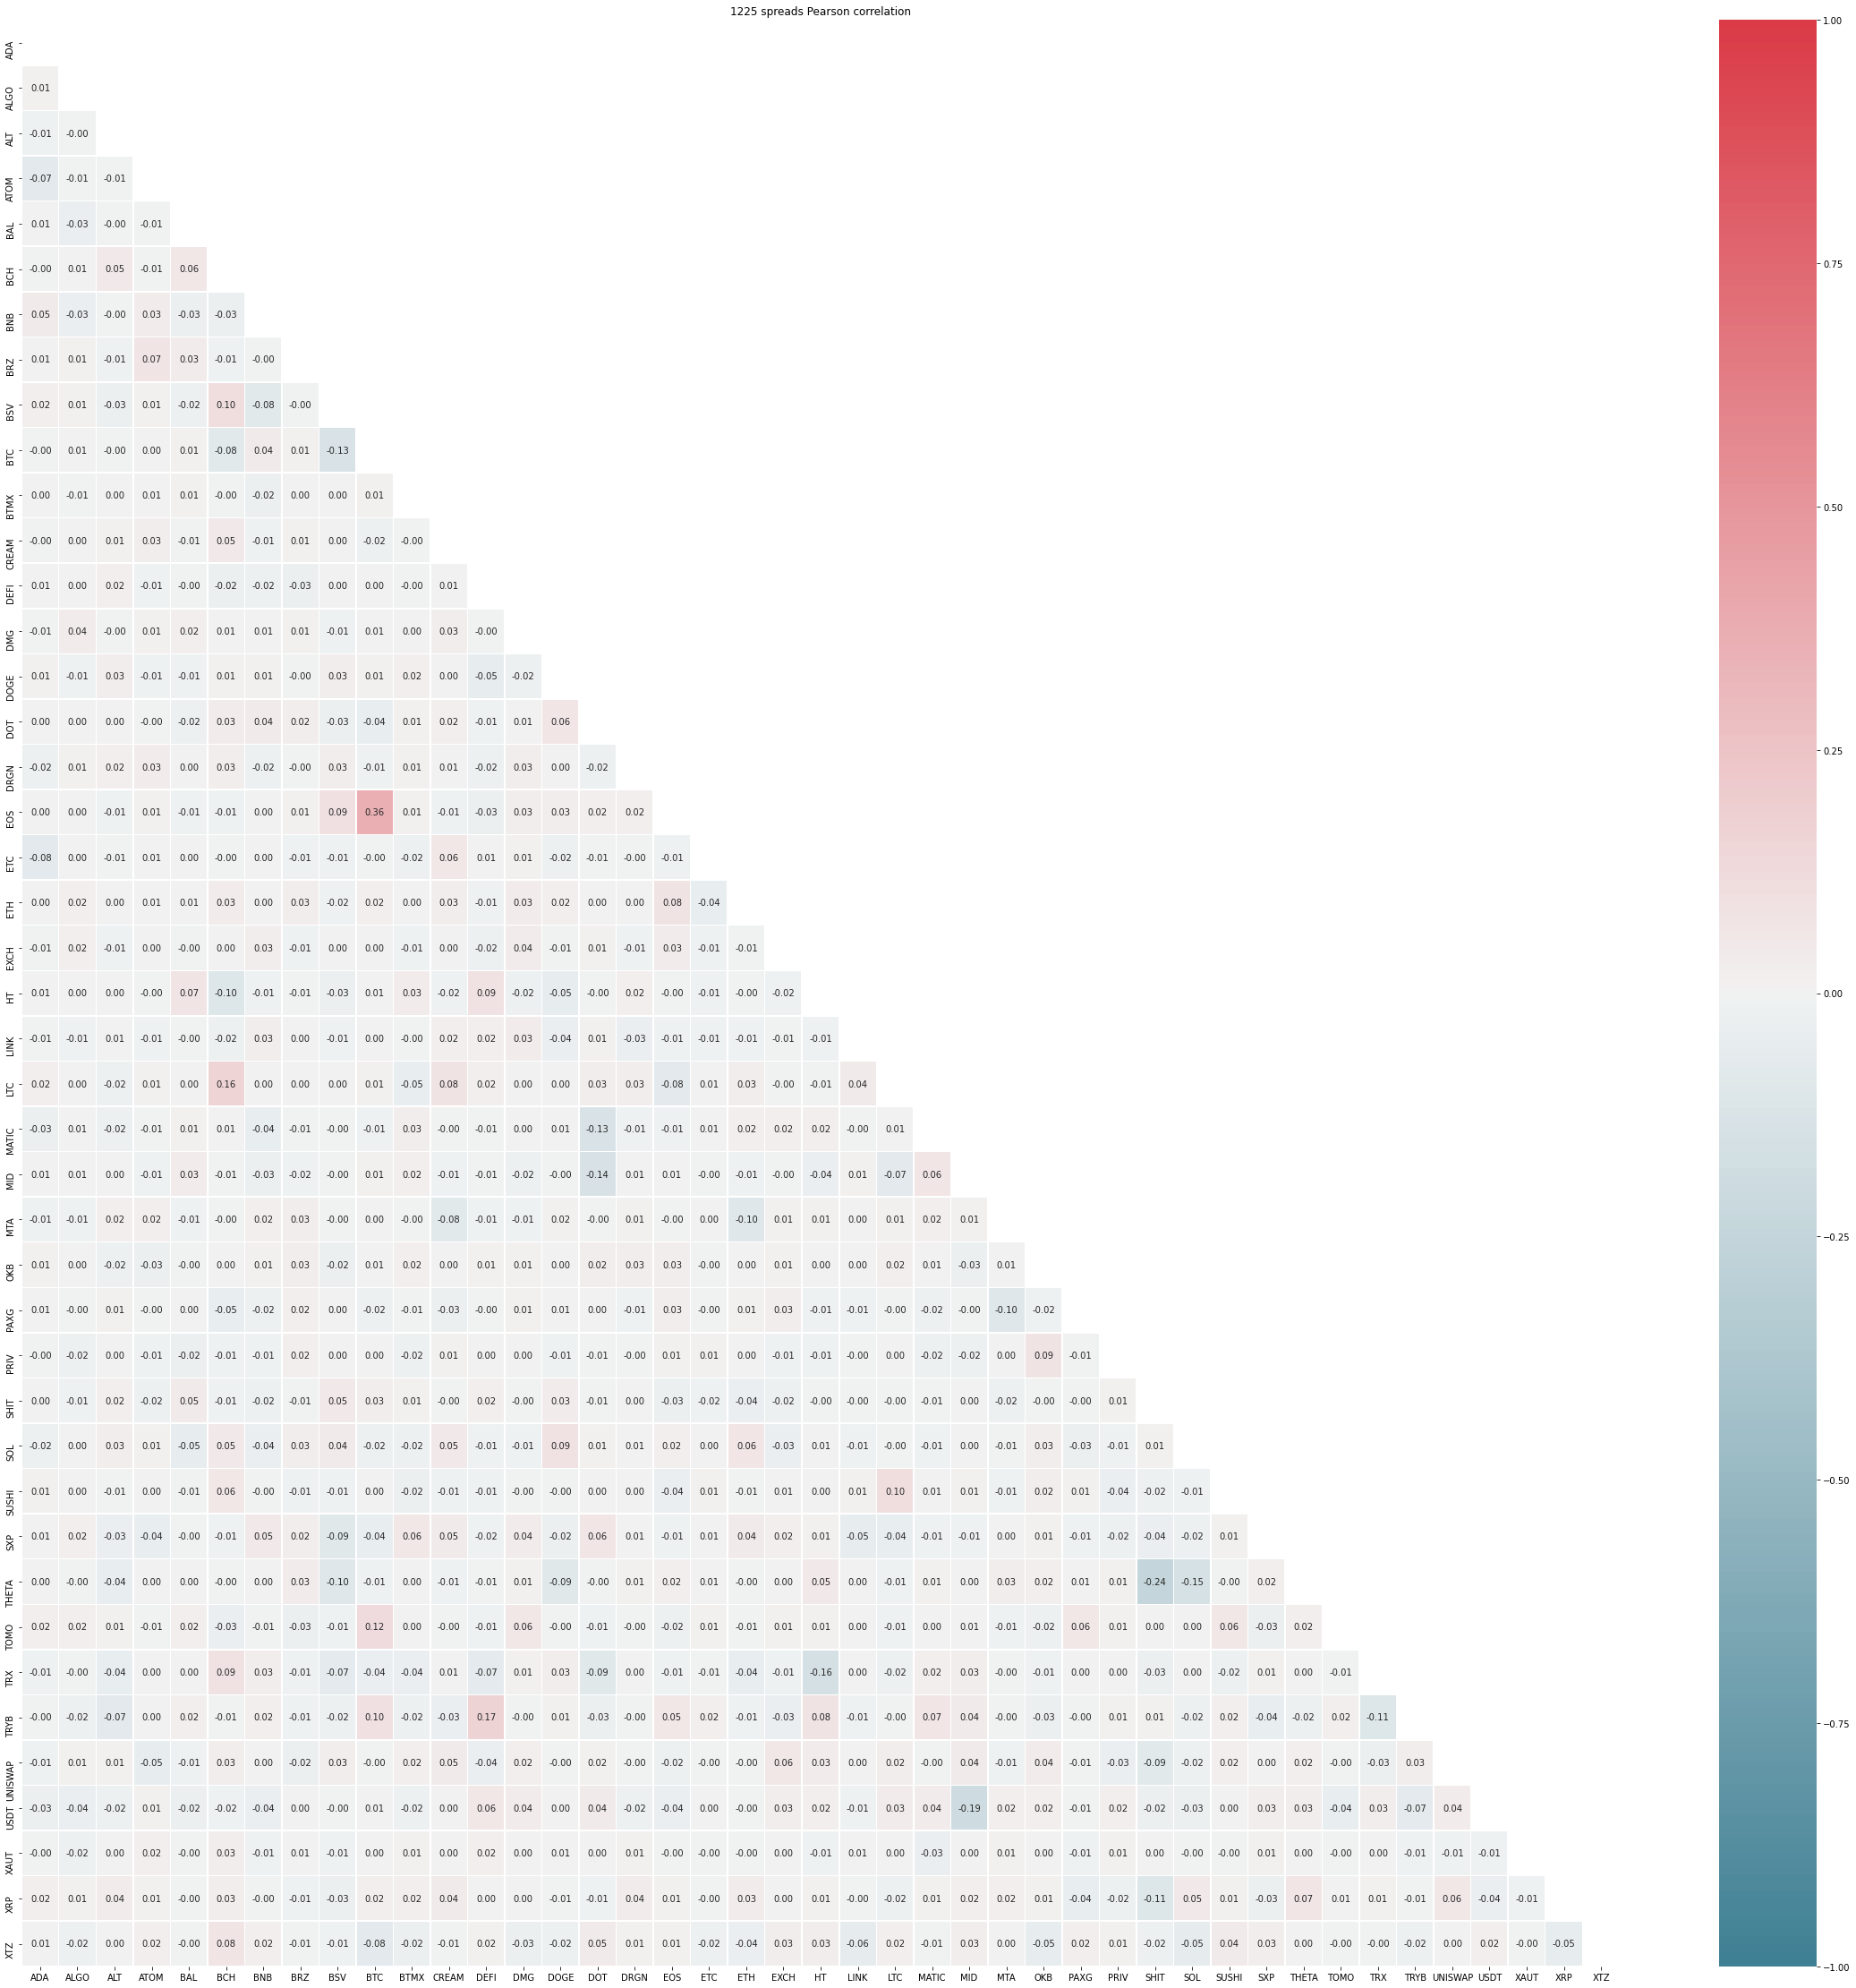

spreads from 2020-09-11T18:40:00+00:00 to 2020-12-25T03:00:00+00:00
['BTC', 'MTA'] have missing values


In [2]:
corr.spreads_correlation_heatmap(futures_date='0326', coint=False, triangular=True, timeframe='H', annot=True)
corr.spreads_correlation_heatmap(futures_date='1225', coint=False, triangular=True, timeframe='H', annot=True)

### however, correlation is not a good trading indicator. For example, if your pairs trading strategy is based on the spread between the prices of the two stocks, it is possible that the prices of the two stocks keep on increasing without ever mean-reverting.
### more reading on correlation vs cointegration https://www.r-bloggers.com/2017/11/cointegration-correlation-and-log-returns/

## Cointegration test among spreads. Here, looking for scores less than 0.05 to reject the null hypothesis that there is no cointegration
###  Cointegration is a statistical property of two or more time-series variables which indicates if a linear combination of the variables is stationary.
### Spread = log(token a) – nlog(token b); 

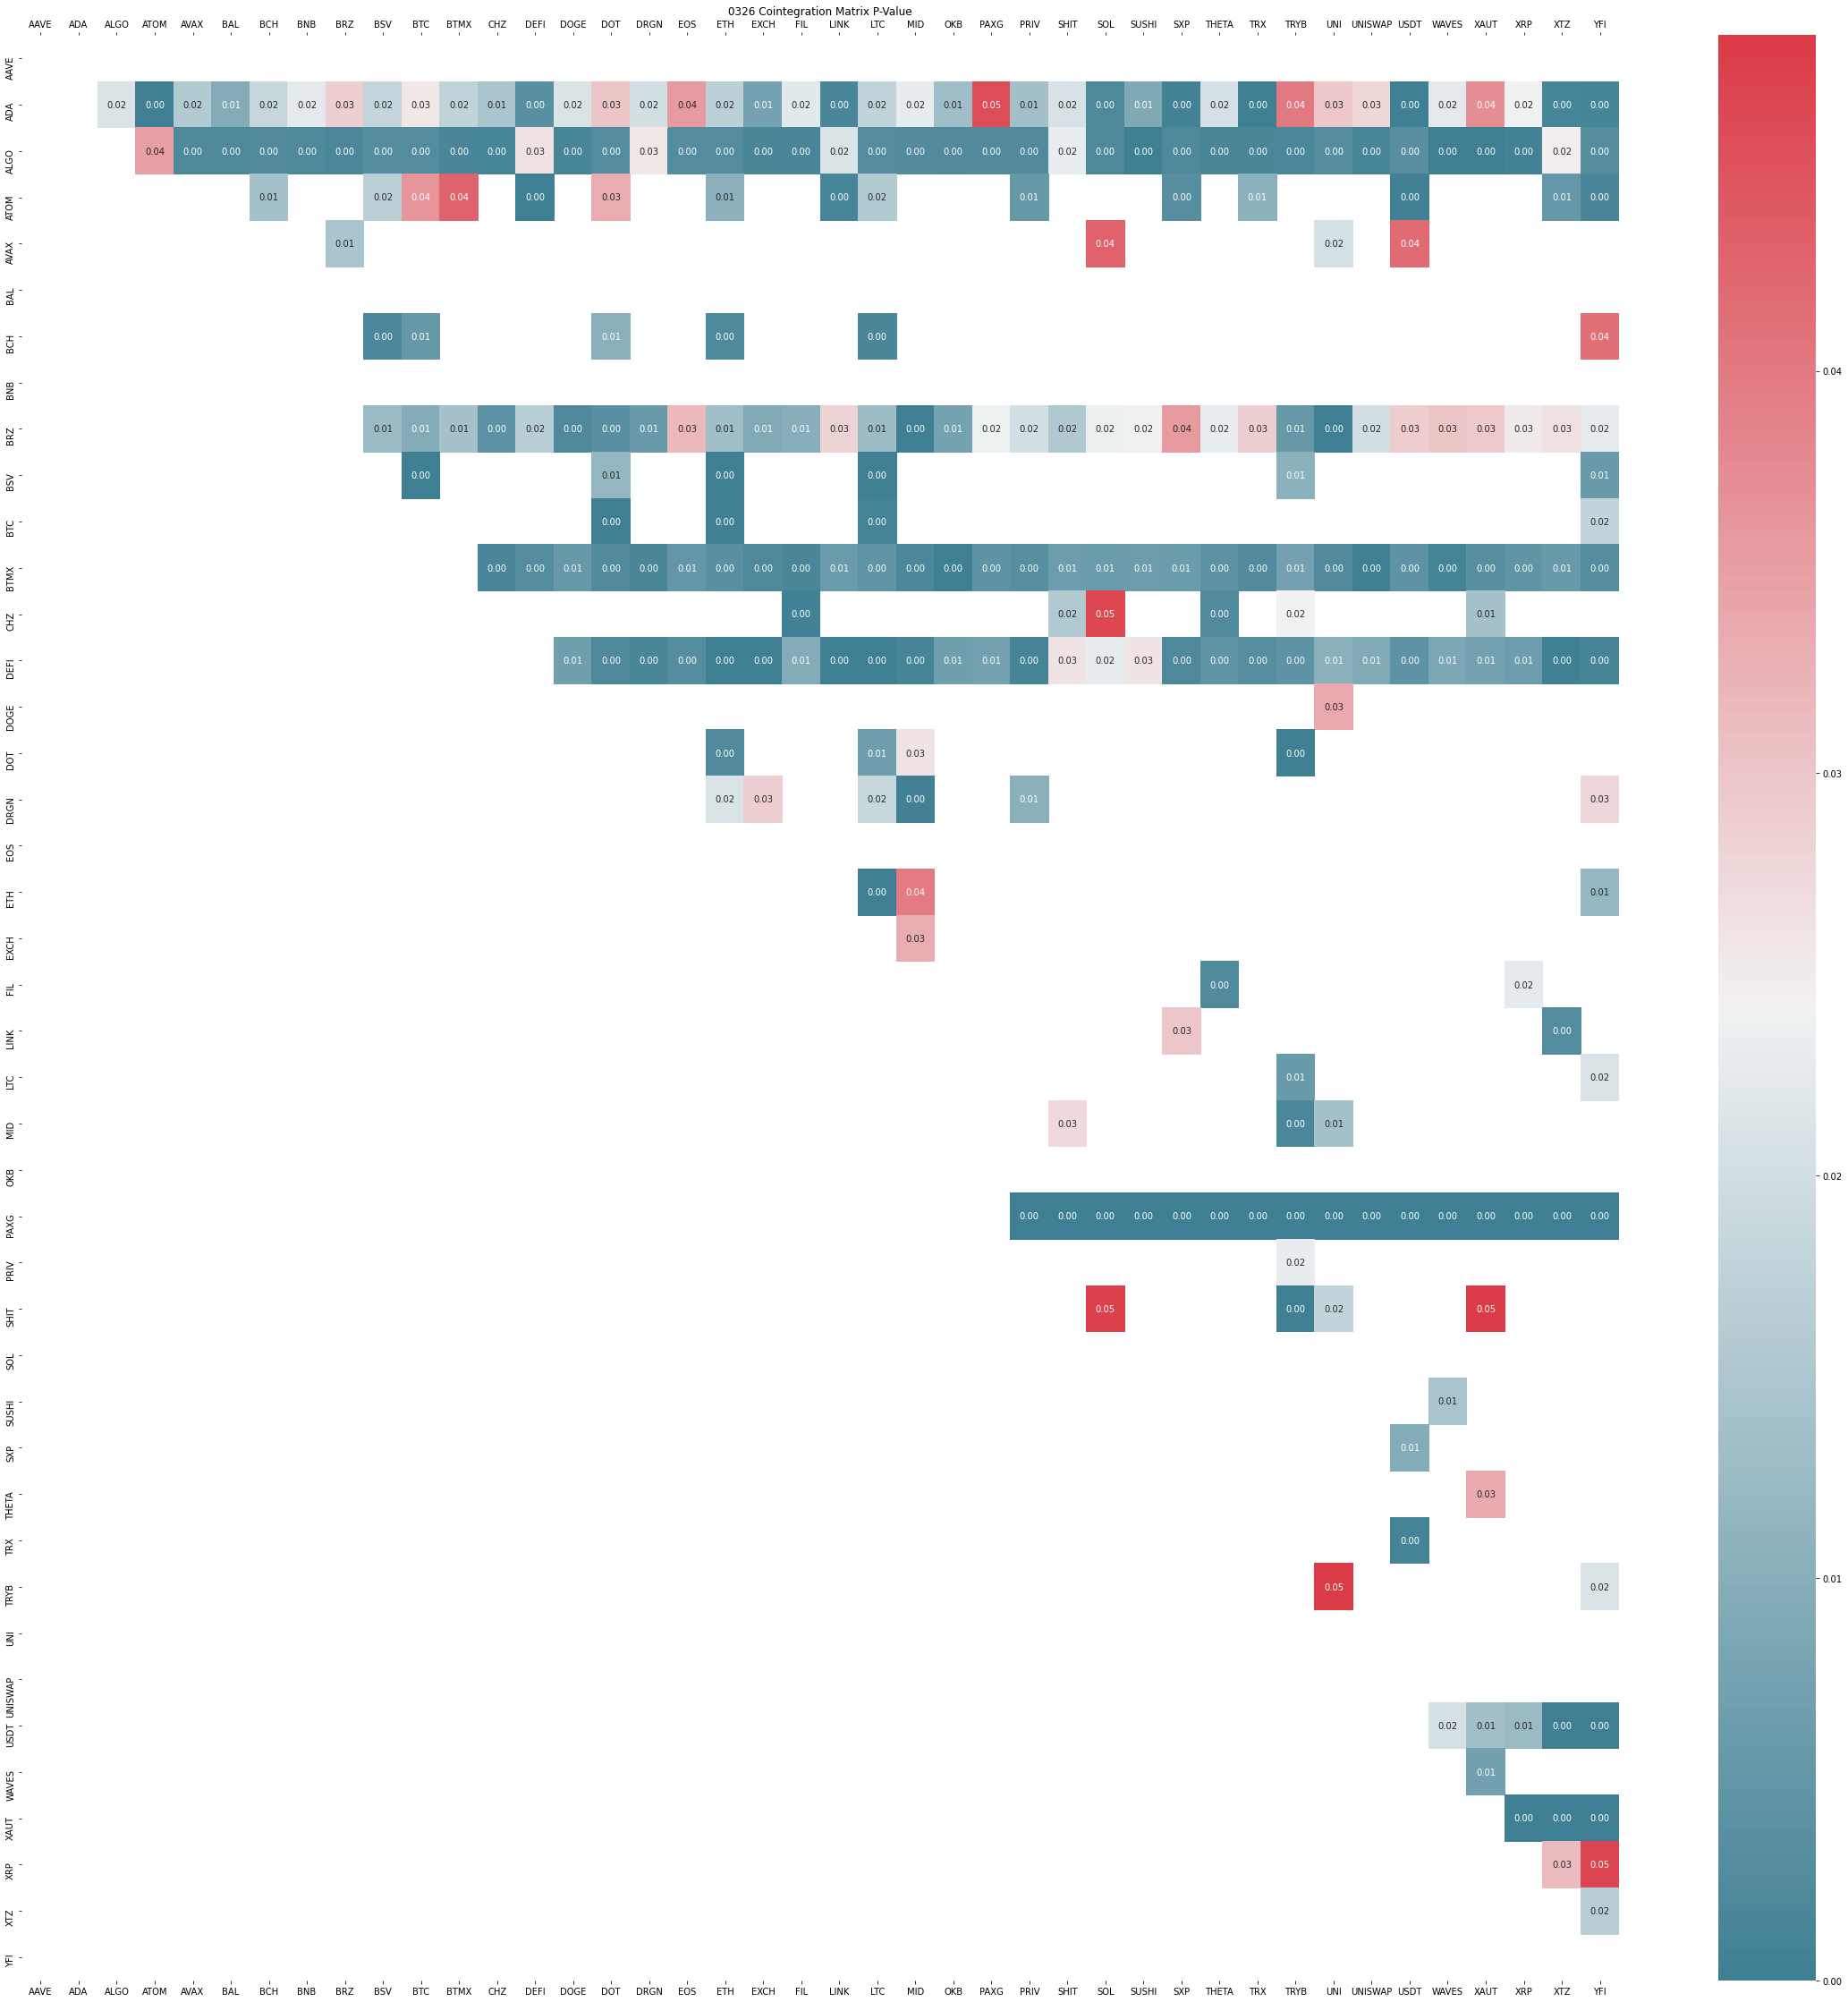

spreads from 2020-12-14T07:27:00+00:00 to 2021-03-26T03:00:00+00:00
['BCH', 'BNB', 'BTC', 'BTMX', 'DEFI', 'DOT', 'EOS', 'ETH', 'FIL', 'LTC', 'SOL', 'SUSHI', 'TRYB', 'USDT', 'WAVES', 'XRP', 'XTZ'] have missing values


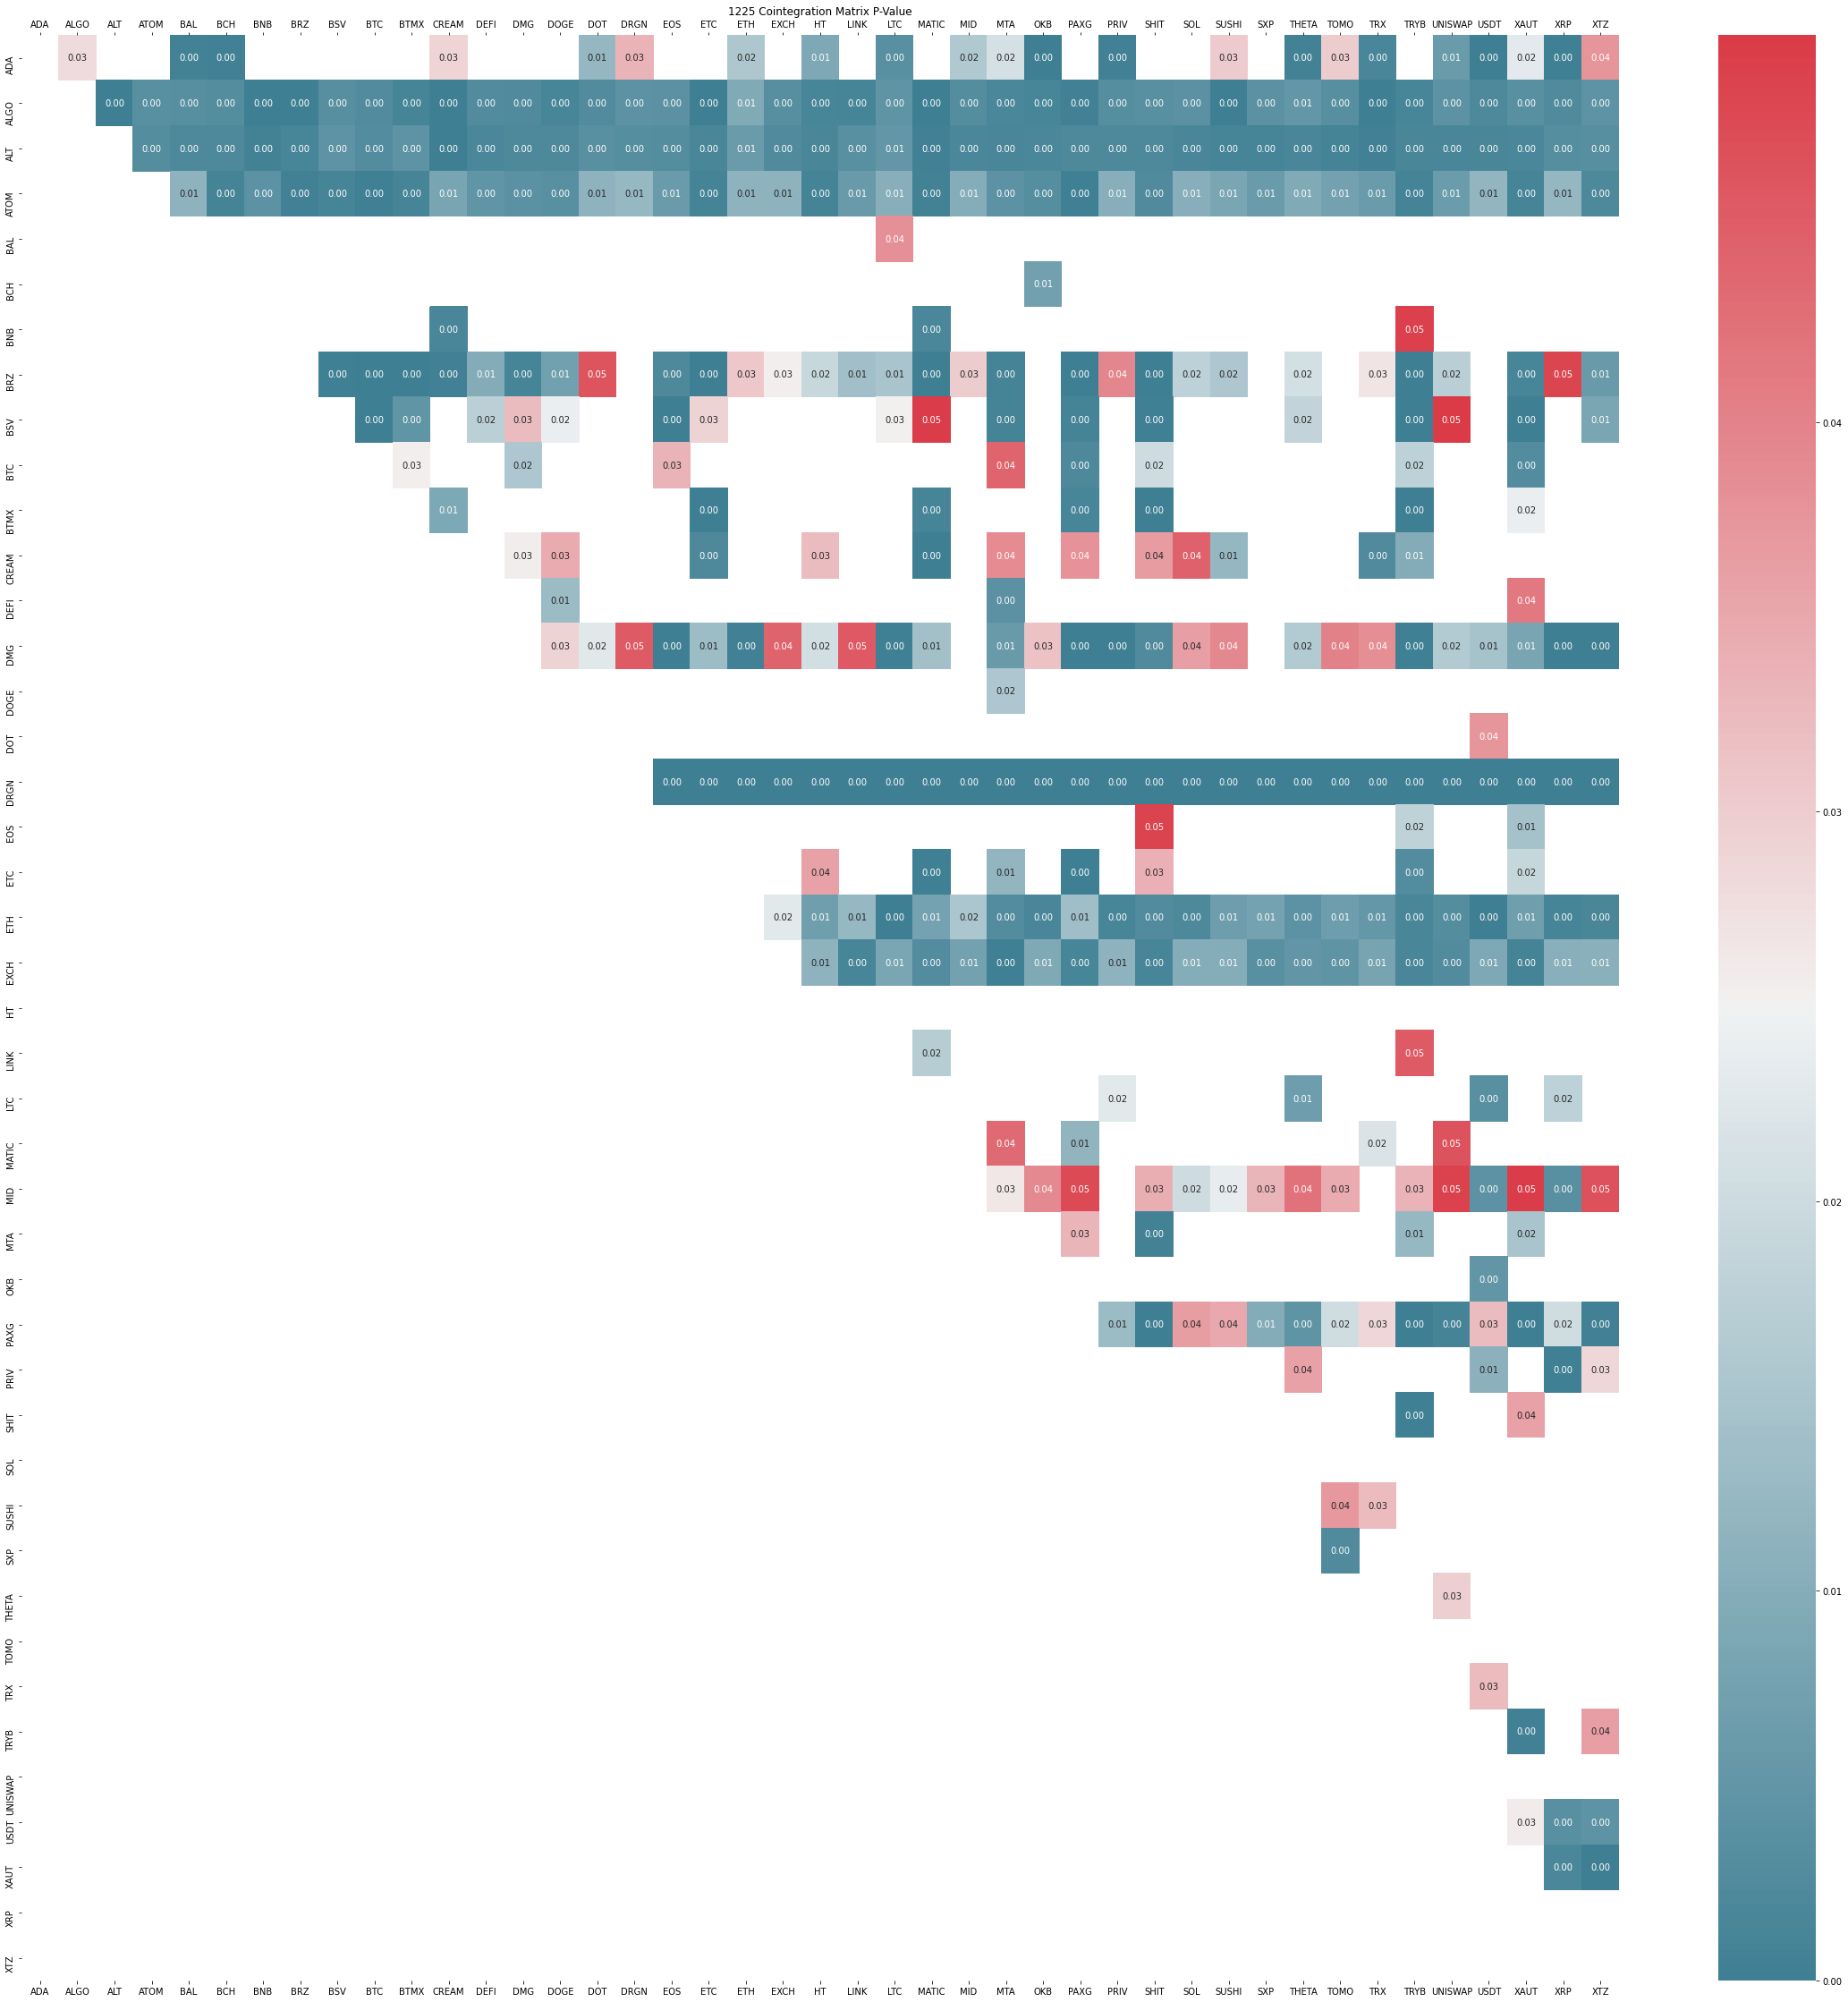

spreads from 2020-09-11T18:40:00+00:00 to 2020-12-25T03:00:00+00:00
['BTC', 'MTA'] have missing values


In [3]:
corr.spreads_correlation_heatmap(futures_date='0326', coint=True, timeframe='H', showing_only_below_threshold=True, annot=True)
corr.spreads_correlation_heatmap(futures_date='1225', coint=True, timeframe='H', showing_only_below_threshold=True, annot=True)


##  perp-future spread cointegration test among different assets (NaN are masked)
### comparing to the above heatmap, where 'spreads of spreads' is being tested, here the subject is only perp-future spread

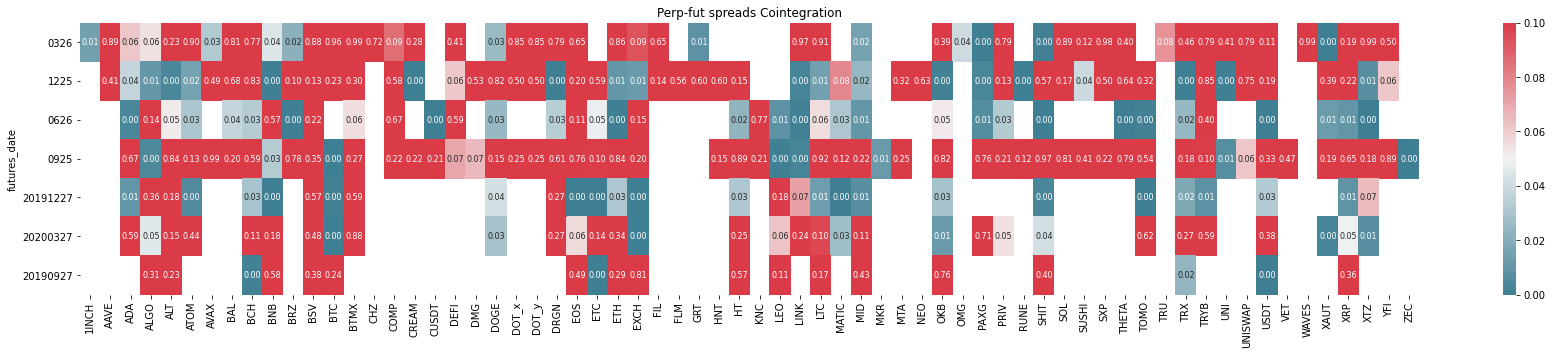

In [4]:
corr.pair_coint(True, '4H')


### here I will select tokens that display consistent cointegration to further test cointegration by calculating the hedge ratio 

### Get a visual sanity check to see the cointegrated pairs' historical spreads 

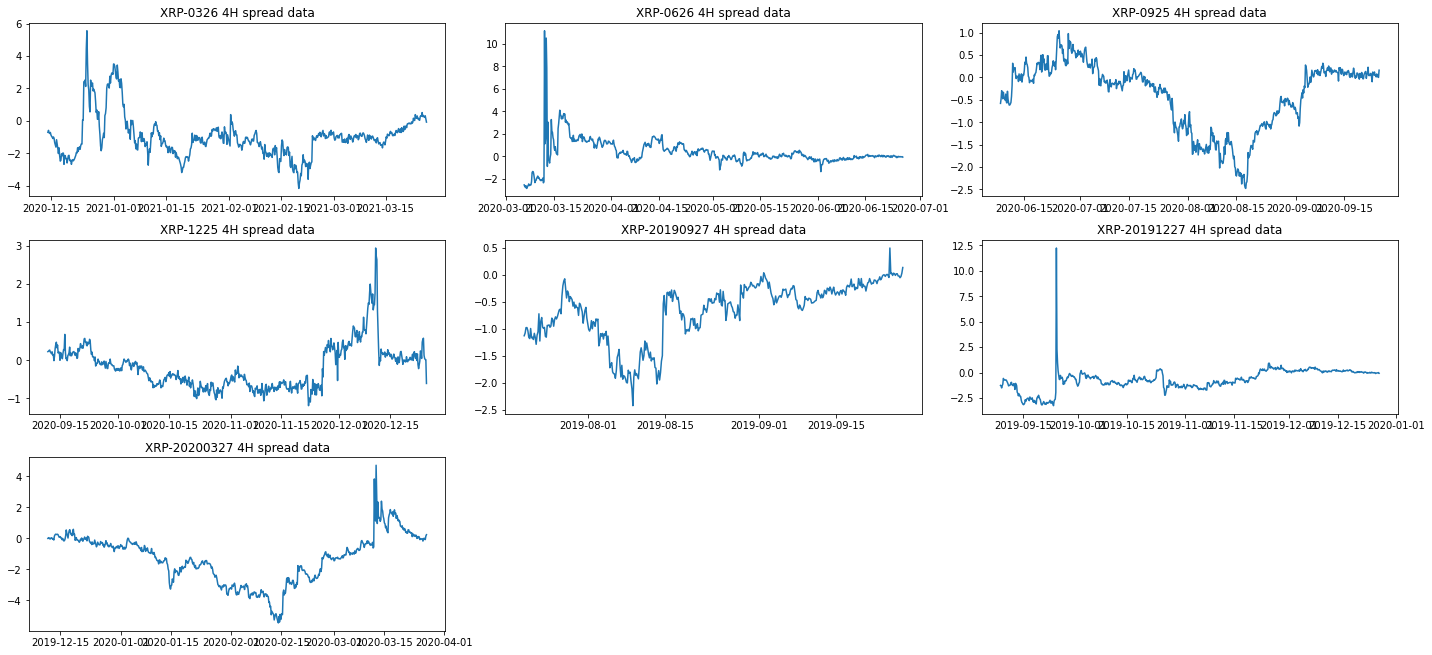

In [136]:
corr.plot_historical_spread('XRP', '4H')


### some of the cointegrated pairs above don't fit the perfect definition of cointegration, in other words, their spreads' variance do seem to vary from time to time. My guess is because I used statsmodels' 'coint' function to calculate the cointegration, and because the underlying test for 'coint' function only tests whether there exists a unit root, data can have varying variance even without the presence of unit root. Therefore, to get more conclusive results, I may need to conduct more tests. i.e. Philip-Ouliaris test, Johansen test

## So far, only a few tokens exibit cointegrated movements in recent past (2021/03/31)

## now we can select the most cointegrated spreads, and explore their (1)historical spread price range, (2)volatility distribution (3)and funding rate volatility 

#### first, lets get the data visualization for the funding rate. This function uses datatime.now(), so it should give you the most up to date funding rate
#### user can choose lookback period in hours (time are denoted in utc time)


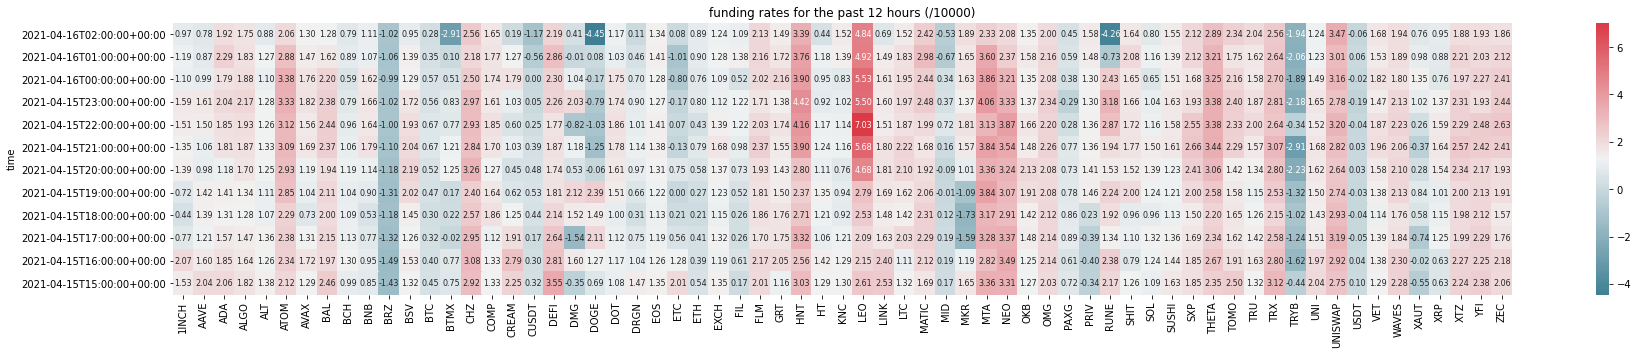

In [3]:
acc.get_latest_funding_for_perps_with_fut(12)

#### then, take a look at the historical funding rate volatility

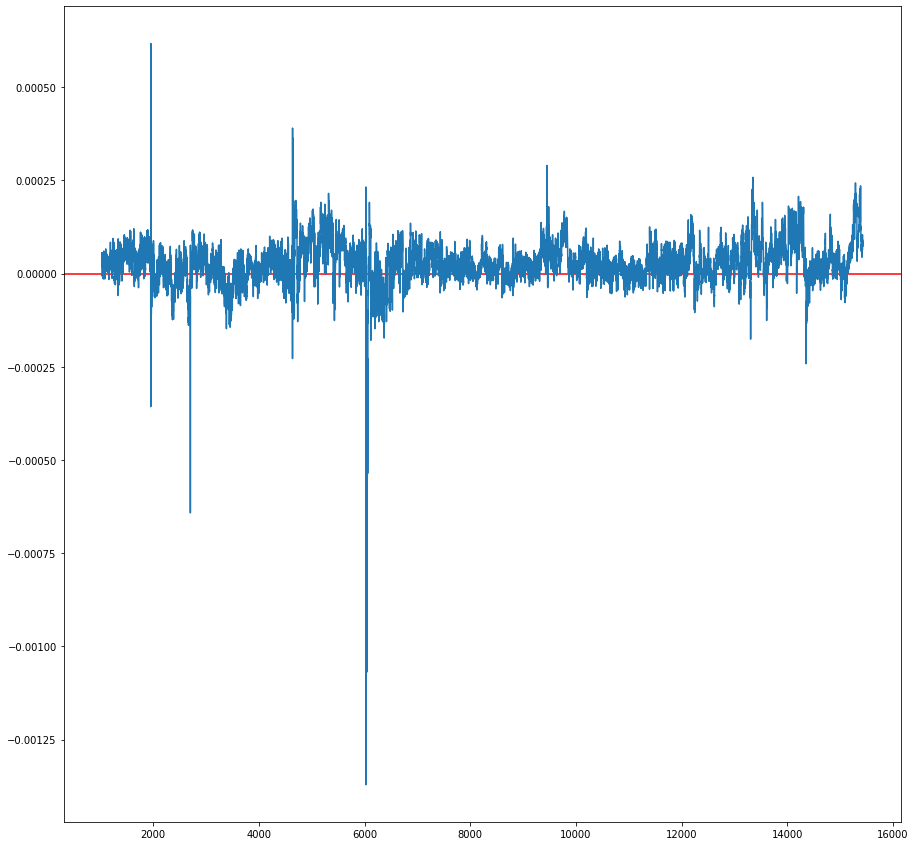

In [130]:
df = pd.read_csv('/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/historical_funding/BSV-PERP_historical_funding_data.csv')
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(df.tail(14400)['rate'])

### below is BNB's spread density curve from 2019-09-27 to 2021-03-26

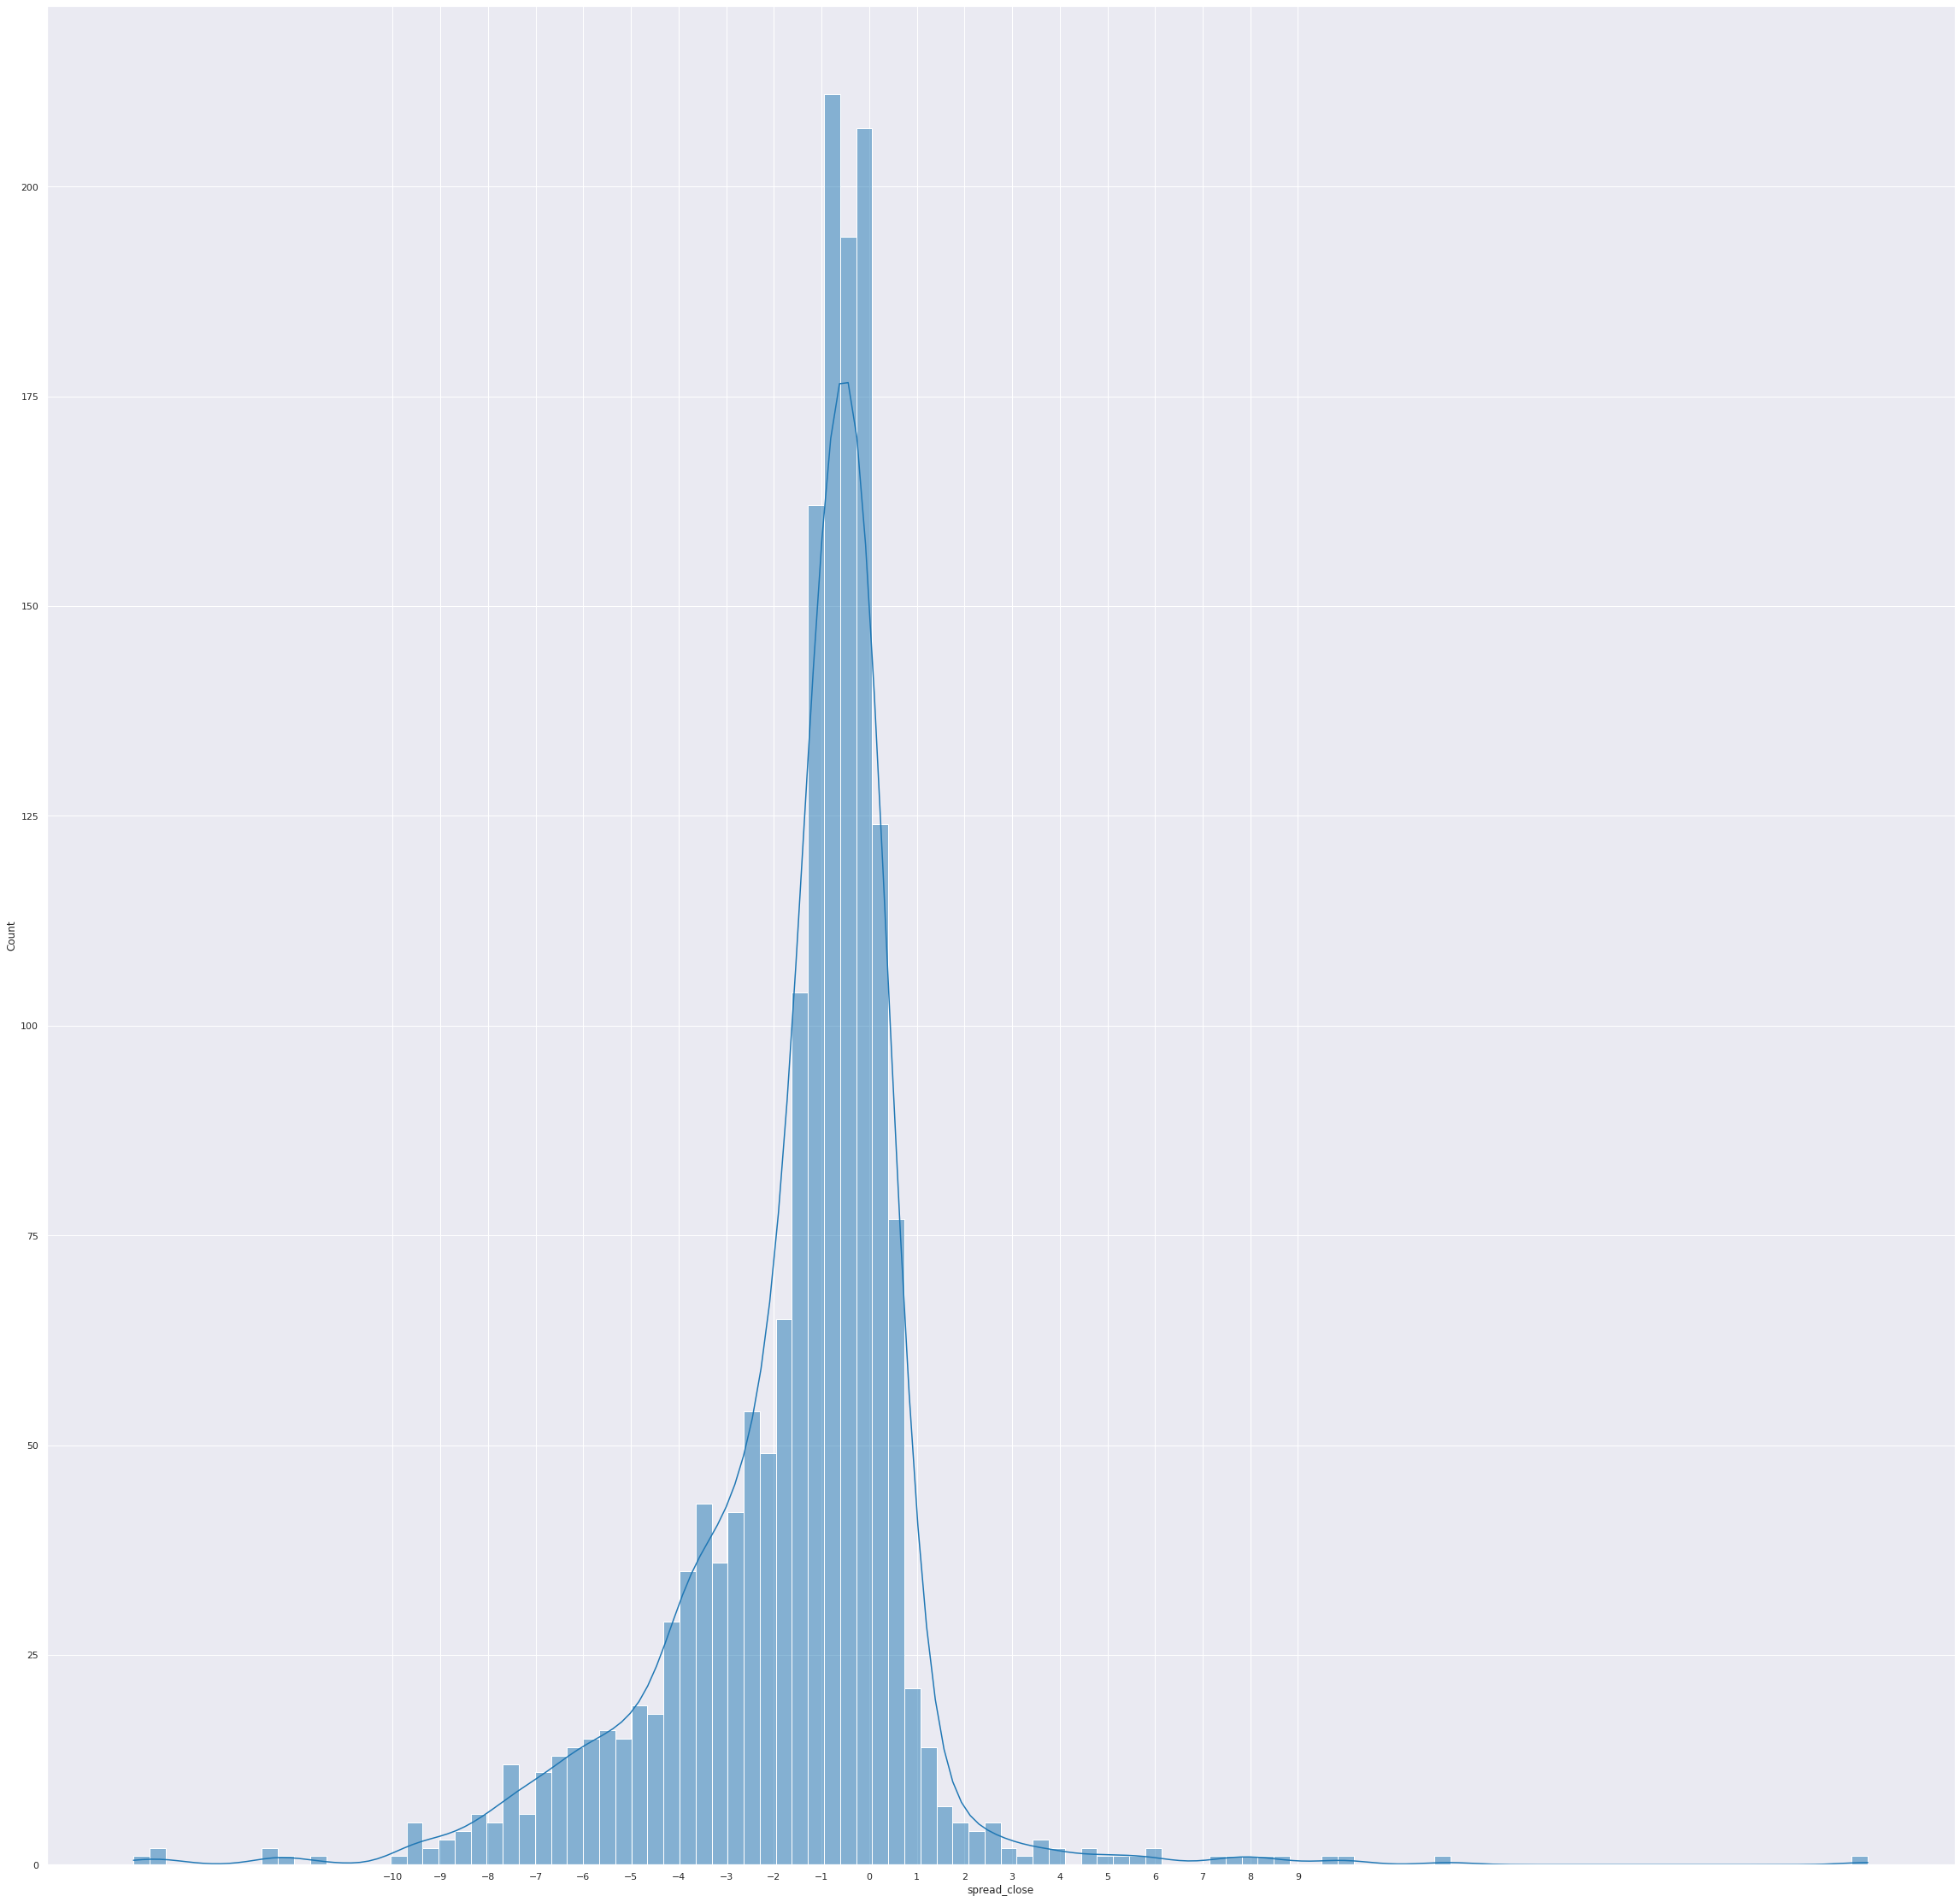

In [8]:
corr.plot_spread_price_distribution('TRU', timeframe='H', histogram=True)


### plot a single futures contract

<AxesSubplot:xlabel='spread_close', ylabel='Count'>

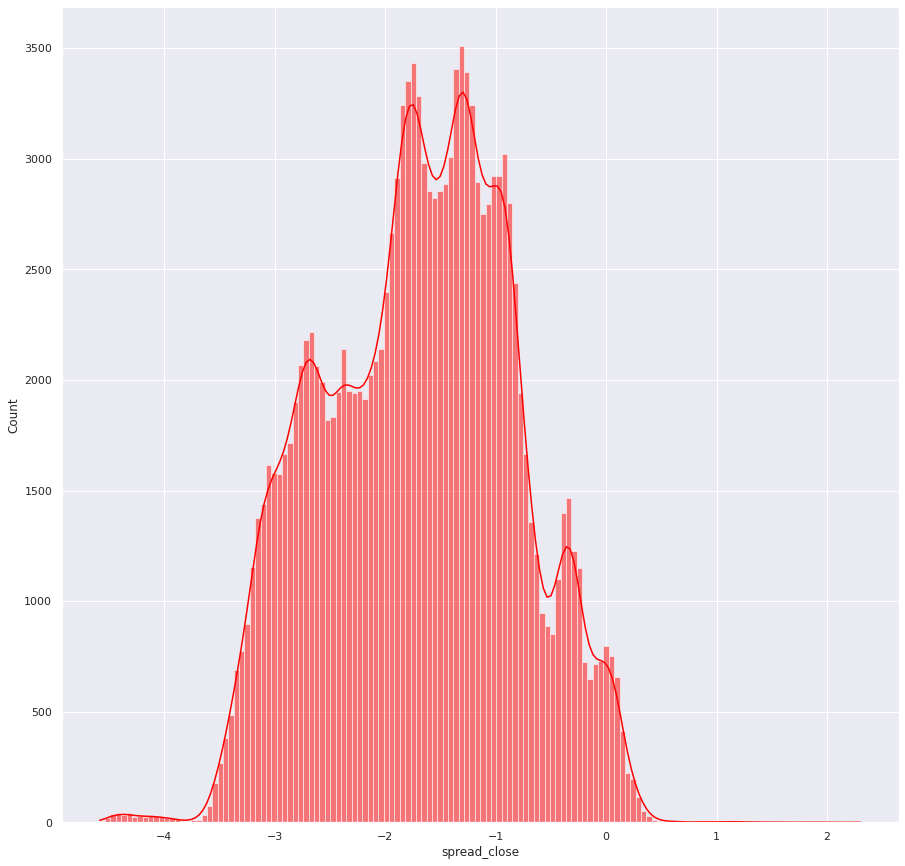

In [9]:
df = pd.read_csv('/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/all_spreads/LINK-0326_spread_data.csv')
sns.histplot(data=df['spread_close'], color='red', kde=True)

### cross calendar spread 
### *all perp denominated
### *only test ETH and BTC due to liquidity concerns

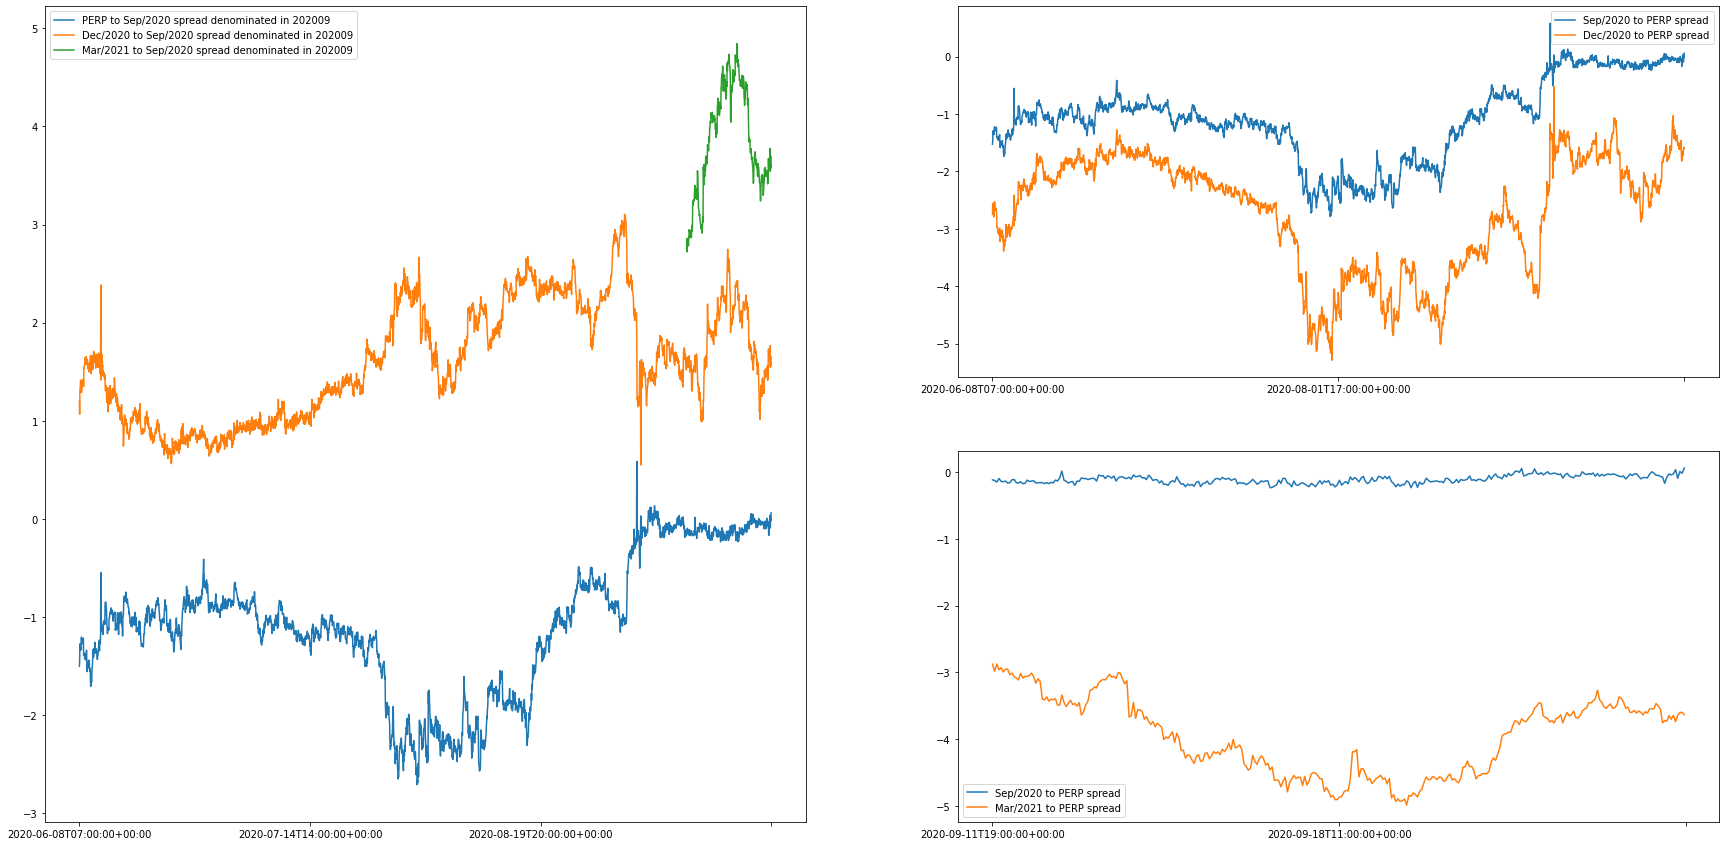

In [133]:
token='BTC'

dfperp = CSVManager(f'/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/all_perps/{token}-PERP_historical_data.csv').change_resolution('H', 'PERP')
# df202003 = CSVManager(f'/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/expired_futures_data/{token}-20200327_60_data.csv').change_resolution('H', 'FUTURE')
# df202006 = CSVManager(f'/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/expired_futures_data/{token}-0626_60_data.csv').change_resolution('H', 'FUTURE')
df202009 = CSVManager(f'/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/expired_futures_data/{token}-0925_60_data.csv').change_resolution('H', 'FUTURE')
df202012 = CSVManager(f'/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/expired_futures_data/{token}-1225_60_data.csv').change_resolution('H', 'FUTURE')
df202103 = CSVManager(f'/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/expired_futures_data/{token}-0326_60_data.csv').change_resolution('H', 'FUTURE')


plot1 = df202009
plot2 = df202012
plot3 = df202103
plot_perp = dfperp

plot1.rename(columns={'open': 'plot1_open', 'high': 'plot1_high', 'low': 'plot1_low',
                                                'close': 'plot1_close', 'volume': 'plot1_volume', 'vwap': 'plot1_vwap'}, inplace=True)
plot2.rename(columns={'open': 'plot2_open', 'high': 'plot2_high', 'low': 'plot2_low',
                                                'close': 'plot2_close', 'volume': 'plot2_volume', 'vwap': 'plot2_vwap'}, inplace=True) 
plot3.rename(columns={'open': 'plot3_open', 'high': 'plot3_high', 'low': 'plot3_low',
                                                'close': 'plot3_close', 'volume': 'plot3_volume', 'vwap': 'plot3_vwap'}, inplace=True) 
plot_perp.rename(columns={'close': 'perp_close'}, inplace=True)


joint_df_near = pd.merge(plot1, plot2, how='inner', on=['timestamp'])
joint_df_near = pd.merge(joint_df_near, plot_perp, how='inner', on=['timestamp'])

joint_df_far = pd.merge(plot1, plot3, how='inner', on=['timestamp'])
joint_df_far = pd.merge(joint_df_far, plot_perp, how='inner', on=['timestamp'])

joint_df_combined = pd.merge(joint_df_near, joint_df_far, how='outer', on=['timestamp', 'perp_close','plot1_close'])

joint_df_near=joint_df_near.set_index('timestamp')
joint_df_far=joint_df_far.set_index('timestamp')
joint_df_combined = joint_df_combined.set_index('timestamp')

length_near = len(joint_df_near)
length_far = len(joint_df_far)
length_comb = len(joint_df_combined)

fig = figure(figsize=(30, 15))
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(224)
ax3 = fig.add_subplot(121)

ax1.plot((joint_df_near['perp_close']-joint_df_near['plot1_close'])/joint_df_near['perp_close']*100, label='Sep/2020 to PERP spread')
ax1.plot((joint_df_near['perp_close']-joint_df_near['plot2_close'])/joint_df_near['perp_close']*100, label='Dec/2020 to PERP spread')
ax1.set_xticks([0, (length_near/2), (length_near/2)*2])
ax1.legend()

ax2.plot((joint_df_far['perp_close']-joint_df_far['plot1_close'])/joint_df_far['perp_close']*100, label='Sep/2020 to PERP spread')
ax2.plot((joint_df_far['perp_close']-joint_df_far['plot3_close'])/joint_df_far['perp_close']*100, label='Mar/2021 to PERP spread')
ax2.set_xticks([0, (length_far/2), (length_far/2)*2])
ax2.legend()

ax3.plot((joint_df_combined['perp_close']-joint_df_combined['plot1_close'])/joint_df_combined['plot1_close']*100, label='PERP to Sep/2020 spread denominated in 202 Sep/2020')
ax3.plot((joint_df_combined['plot2_close']-joint_df_combined['plot1_close'])/joint_df_combined['plot1_close']*100, label='Dec/2020 to Sep/2020 spread denominated in  Sep/2020')
ax3.plot((joint_df_combined['plot3_close']-joint_df_combined['plot1_close'])/joint_df_combined['plot1_close']*100, label='Mar/2021 to Sep/2020 spread denominated in  Sep/2020')
ax3.set_xticks([0, (length_comb/3), (length_comb/3)*2, (length_comb/3)*3])
ax3.legend()